# VQ-VAE in PyTorch

Example of Vector Quantized Variational Auto Encoder (VQ-VAE) presented by [Aäron van den Oord](https://avdnoord.github.io/homepage/vqvae/). We refer to it's network architecture on [github](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb). We trained that network on our customized [Microsoft CelebA](https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/ms-celeb-images-cropped-aligned.zip) dataset. 
We see how well this network is able to learn face representations, see quantized vector embeddings projected in 3D space and explore how well the network learns face features. 

## IMPORTANT: Install TensorBoard (for  Google Colab)

We need to have up to date `tensorflow` installation (version 2.1.0) otherwise we can't use embedded `tensorboard` in cell output to show some advanced interactive visualizations.

Cell bellow checks the version of tensorflow and updates if necessary. Since Google Colab isn't able to automatically update imported libraries we have to **restart runtime** (you will see button `RESTART RUNTIME`, just press it and run notebook again)  

In [49]:
import tensorflow

if tensorflow.__version__ != '2.1.0':
  !pip install --upgrade tensorflow tensorboard grpcio==1.24.3 google-auth==1.6.3

## Set GPU for Runtime

<p id="7ecb" class="gy gz ef at ha b hb ja hd jb hf jc hh jd hj je hl" data-selectable-paragraph="">It is so simple to alter default hardware <strong class="ha hm">(CPU to GPU or vice versa)</strong>; just follow <strong class="ha hm">Edit &gt; Notebook settings</strong> or <strong class="ha hm">Runtime&gt;Change runtime type </strong>and <strong class="ha hm">select GPU </strong>as <strong class="ha hm">Hardware accelerator</strong>.</p>

![tittle](https://miro.medium.com/max/740/1*WNovJnpGMOys8Rv7YIsZzA.png)

## Import Libraries

In [2]:
import os

from typing import List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from scipy.signal import savgol_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

%reload_ext tensorboard

## Set Device

If you have correctly chosen GPU device then you will have `device=="cuda"`

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device

device(type='cuda')

## CelebA Dataset

We will use CelebA dataset consisting of RGB celebrity face images along with facial characteristic features that we will see below.

The dataset can be downloaded from Kaggle:
https://www.kaggle.com/jessicali9530/celeba-dataset

We will use pre-processed version of the dataset, where pictures have been aligned in center and also excess border has been cropped so that only face occupies the whole image.

## Retrieve Dataset

Download our **Customized Microsoft CelebA Dataset** from S3 public bucket (cropped and face aligned images of celebrities and their 40 face attributes)

In [4]:
if not os.path.exists("data"):
    # Get dataset archive
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/ms-celeb-images-cropped-aligned.zip
    # Unzip directories and files
    !unzip ms-celeb-images-cropped-aligned.zip > /dev/null

## Set Global Variables for CelebA dataset

Here we define some global variables.

Batch size will be used for dataloaders and default statistics variable will store mean and variance for dataset normalization. Empirically [0.5]*3, [1.0]*3 worked well and used that one

In [50]:
DEFAULT_STATS = [0.5]*3, [1.0]*3

DATA_DIR = 'data'
DATA_BATCH_SIZE = 64

## Create Dataset

We create our custom dataset class. It has transforms which **resizes** images in `64x64` dimension and **normalizes** with `DEFAULT_STATS` defined above

In [6]:
class CelebFaceDataset(torch.utils.data.dataset.Dataset):
    
    def __init__(self, root_dir: str, image_ids: List[str], data_stats:Tuple[List[float], List[float]]):
        """
        Args:
            root_dir: directory of images
            image_ids: list of ids (filename) of images
            data_stats: mean and std values for 3 channels of image (for normalization)
        """
        self.root_dir = root_dir
        self.image_ids = image_ids
        self.transforms = transforms.Compose([
                                              transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*data_stats)
                                             ]) 
    def __getitem__(self, idx: int):
        """
        Args:
            idx: index of image in image_ids list
        Returns:
            Tensor: Loaded and transformed (resize+normalization) image
        """
        image = PIL.Image.open(os.path.join(self.root_dir, self.image_ids[idx]))

        return self.transforms(image)
    
    def get_by_id(self, image_id: str):
        """
        Args:
            image_id: image file name.
        Returns:
            Tensor: Loaded and transformed (resize+normalization) image
        """
        
        image = PIL.Image.open(os.path.join(self.root_dir, image_id))

        return self.transforms(image)
    
    def __len__(self):
        """
        Returns:
            int: number of images in dataset
        """
        return len(self.image_ids)

`Denormalize` class transforms images back to original form. We use that for visualizations. 

In [7]:
class DeNormalize:
    
    def __init__(self, mean:List[float], std:List[float]):
        """
        Args:
            mean: mean values for 3 channels
            std: std values for 3 channels
        """
        self.mean = mean
        self.std = std

    def __call__(self, image, inplace=False):
        
        """
        Args:
            image: Tensor image of size (C, H, W) to be normalized.
            inplace: inplace or create copy of image tensor
        Returns:
            Tensor: denormalized image (into original form).
        """
        tensor = image if inplace else image.clone()
        
        for tensor_channel, channel_mean, channel_std in zip(tensor, self.mean, self.std):
            tensor_channel.mul_(channel_std).add_(channel_mean)
        
        return tensor

Here we define `CelebA` dataset dataloader which wraps already defined dataset. It shuffles image ids, splits them into train and validation set with some proportion and return separated dataloader class objects 

In [8]:
def get_celeba_dls(df: pd.DataFrame, data_stats:Tuple[List[float], List[float]], valid_size:float=0.01, 
                   batch_size:int=128):
    """
        Args:
            df: dataframe of image ids (filenames) and 40 attribute values (-1 or 1) 
            data_stats: mean and std values for 3 channels of image (for normalization)
            valid_size: size of validation set (fraction value)
            batch_size: size of the batch for training and validation set dataloaders
        Returns:
            (Dataloader, Dataloader): Training and Validation set dataloader objects.
    """
    train_ids, valid_ids = train_test_split(df.image_id.tolist(), test_size=valid_size)
    
    print('Train size:', len(train_ids), 'Valid Size:', len(valid_ids))
    
    train_ds = CelebFaceDataset(DATA_DIR + '/celeba', train_ids, data_stats)
    valid_ds = CelebFaceDataset(DATA_DIR + '/celeba', valid_ids, data_stats)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=batch_size, 
                                        shuffle=True, 
                                        pin_memory=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=batch_size,
                                        shuffle=False, 
                                        pin_memory=True))

### Read dataset Attributes File 

We have attributes for each face images describing some conceptual features for the face (sunglasses, eyebrows, etc)

In [9]:
attr_df = pd.read_csv(DATA_DIR + '/list_attr_celeba.csv')

In [10]:
attr_df.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000005.jpg                -1                1           1               -1   
3  000006.jpg                -1                1           1               -1   
4  000007.jpg                 1               -1           1                1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1         1        -1          -1  ...         -1       -1   
4    -1     -1         1         1           1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1         -1                -1           -1                 1   
3             -1          1                 1           -1                 1   
4              1         -1                -1           -1                -1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                -1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

### Create Denormalizer Object

We will use it each time to denormalize and visualize image

In [11]:
denorm = DeNormalize(*DEFAULT_STATS)

### Get Train/Test Dataloaders

In [12]:
train_dl, valid_dl = get_celeba_dls(df=attr_df, data_stats=DEFAULT_STATS, batch_size=DATA_BATCH_SIZE)

Train size: 194727 Valid Size: 1967


### Show samples from Training Data

In [13]:
def show(img:torch.Tensor, title=None, figsize=(15, 15)):
    np_img = img.permute(1,2,0).numpy()
    plt.figure(figsize=figsize)
    fig = plt.imshow(np_img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)
    plt.show()

In [14]:
def show_batch(batch, samples=None, title=None, figsize=(15, 15)):
    if not samples:
        samples = batch.shape[0]
        
    denorm_batch = torch.stack([denorm(batch[i]) for i in range(samples)])
    batch_grid = make_grid(denorm_batch)
    show(batch_grid, title, figsize)

In [15]:
sample_batch = next(iter(train_dl))

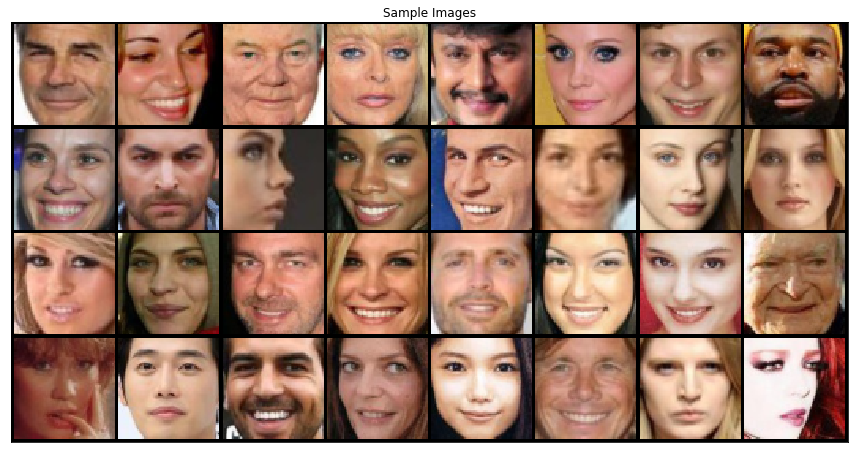

In [16]:
show_batch(sample_batch, samples=32, title='Sample Images')

## Model Architecture Scheme (for 32x32 images)

Here is the model architecture from original paper by [Aäron van den Oord](https://avdnoord.github.io/homepage/vqvae/)

![title](https://github.com/zalandoresearch/pytorch-vq-vae/raw/b98fde9a8f8f65486dbfaf12958049e8d33184a1/images/vq-vae.png)

We see here that we are taking batch of images, encode them, into some feature space, then we reshape that feature space BCHW into BHWC and then (B*H*W)C. So for each image we are getting H*W number of C dimensional vectors.
We have also CodeBook of quantized vectors which are randomly sampled at the beginning but are learned through backpropagation. On each step Encoder output as vectors will be matched to closest embedding vectors from codebook, then transformed back from (B*H*W)C to BHWC and then BCHW (So we get original shape from Encoder output). We will pass that quantized Encoder output to Decoder which decodes it and we get reconstructed image.    

## Encoder Architecture

Here we have defined a residual unit with (Relu, Conv2d, ReLU, Conv2D). It will be used in our Encoder and decoder networks.

In [15]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)

Residual stack is created to conveniently stack residual units using nn.ModuleList. 

In [16]:
class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

Encoder has 3 layers of 2D convolutions. Then residual stack.

In [51]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[64, 64, 16, 16]`, we will first convert it to an `BHWC` tensor of shape `[64, 16, 16, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [18]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings:int, embedding_dim:int, commitment_cost:float):
        """
        Args:
            num_embeddings: number of embeddings to have in Quantizer CodeBook 
            embedding_dim: dimension of embedding vectors
            commitment_cost: coefficient of cost for latent vectors (from encoder)
        """
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._commitment_cost = commitment_cost
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        
        # initialize embedding with continuous uniform distribution with P(x)=1/(-1/n_emb - 1/n_emb) 
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        
    def forward(self, inputs):
        """
        Args:
            inputs: latent vectors which are outputs of encoder 
        Returns:
            (Tensor, Tensor, Tensor, Tensor): Calculated loss, quantized vectors,  Calculated perplexity and encodings
        """
                # convert inputs from BCHW -> BHWC
        # We are going to use Channel dimension to quantize image features which were encoded by Encoder network
        inputs = inputs.permute(0, 2, 3, 1).contiguous() 
        
        # Flatten input to get (B*H*W)C
        # We get (B*H*W) vectors of dimension C.
        # If we have B=1 (one image only) we have (H*W) number of vectors of C dimension.
        # (H*W) number of vectors can become (H*W) discrete features and will explain our 
        # image (face attributes/features) but we don't have guarantee that quantized vectors in codebook
        # correspond to disentangled features of image easily interpretable for human (like: Eyeglasses, 
        # GrayHair, Mustache, NarrowEyes, etc).
        # Quantized vectors are latent features which are combinations of many features together.
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # We have embedding matrix of KD dimension (K == number of vectors,  D == vector's dimension)
        # Here we are calculating euclidean distance between (B*H*W) number of C dimensional vectors and 
        # K number of D dimensional codebook vectors. (Notice that dimension of image channels and dimension of 
        # codebook vectors are equal (C==D))
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Here we find indices of closest vectors of codebook vectors for each image vectors
        # Here torch.scatter function converts found indices to one-hot vectors and 
        # we get matrix of dimension (B*H*W)K where element of i-th row and j-th column is 1 if 
        # i-th vector's (from image latent vectors) closest to j-th vector from codebook 
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Now we just multiply matrix of one-hot encodings to codebook matrix to get quantized vectors 
        # So we multiply matrix of one-hot vectors of shape (B*H*W)K to matrix of KD and we get
        # quantized vectors matrix of shape (B*H*W)D or (B*H*W)C (because C==D)
        # Intuitively we just replaced latent features from encoder with closest latent features 
        # from our codebook which is well known for decoder.
        quantized = torch.matmul(encodings, self._embedding.weight).view(inputs.shape)
        
        # As our reconstructions fully depend on codebook latent vectors, we need to use them efficiently
        # and encode as much information as possible to give best feature descriptions to decoder which will
        # try to reconstruct the original image. 
        
        # 1) To achieve this we need to have feature vectors generated by encoder network as close as possible
        # to our codebook vectors. This is done by `EncoderLatentLoss` minimization. We are actually 
        # bringing encoder latent vectors close to codebook vectors. (Here you see that quantized 
        # vectors are detached to stop gradient computation for them and only optimize encoder latents)
        
        # 2) Also we need to optimize usage of quantized codebook vectors to compress the information as much  
        # as possible and generate broad latent vectors covering many features of images. 
        # This is done by `QuantizedLatentLoss` minimization. We are actually 
        # bringing codebook latent vectors close to encoder latent vectors. (Here you see that encoder latent vectors
        # are detached to stop gradient computation for them and only optimize quantized codebook latents vectors)
        
        # Loss = commitment_cost * ||sg[q]-e|| + ||q-sg[e]||  (sg - STOP_GRADIENT operation)
        # Commitment cost is coefficient for encoder latent loss which is (0, 1) range 
        # (commitment_cost=0.25 is recommended from author)
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        # Trick used here is for gradient copying from decoder to encoder without touching quantization part
        quantized = inputs + (quantized - inputs).detach()
        
        # Here we calculate average usage of each quantized vector in quantization (how many times each codebook 
        # latent vector was assigned to encoder latent vectors)
        avg_probs = torch.mean(encodings, dim=0)
        
        # We calculate perplexity of codebook usage which will be used later for loss calculation in training loop
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized vectors from BHWC -> BCHW to pass to decoder
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Decoder Architecture

Here we need to reconstruct image from compressed representation. We first do strided 2d convolution, then run through residual stack and then we use 2d transposed convolutions to decompress and reconstruct original image

In [52]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)


## Model

Model contains encoder, quantization part and decoder

In [20]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        
        self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
            
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity
    
    def quantize(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        _, quantized, _ , _ = self._vq_vae(z)
        
        return quantized
    
    def encode(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        
        return z
        
    def decode(self, z):
        x_recon = self._decoder(z)
        
        return x_recon

## Projecting Model CodeBook of Quantized Vectors

We use this function to visualize `quantized vectors` before and after training to see how they are transformed. We save them with different tags to easily find them in `tensorboard projector`

In [21]:
def add_quantized_vectors_to_projector(model:nn.Module, tag:str=None):
    """
    Args:
        model: torch model (VQ-VAE)
        tag: tag for embeddings to find easily in tensorboard logs
    """
    quantized_vectors = model._vq_vae._embedding.weight.data.cpu()
    writer = SummaryWriter()
    writer.add_embedding(quantized_vectors, tag=tag)
    writer.close()

## Train

### Define Hyperparameters

In [22]:
batch_size = 256
num_training_updates = 500

num_hiddens = 512
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64

num_embeddings = 512

commitment_cost = 0.25

learning_rate = 1e-3

RELU_NEG_SLOPE = 0.2

SHOW_EVERY_N_ITERATION = 100

# default variance not calculated on given data.
DATASET_VARIANCE = 1.0

### Initialize Model and Optimizer

In [23]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens, 
              num_embeddings, embedding_dim, 
              commitment_cost).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

### add quantized vectors in projector before training

In [26]:
add_quantized_vectors_to_projector(model, tag='initialized_model')

### Start Training the Model

100 iterations
recon_error: 0.028
perplexity: 2.721



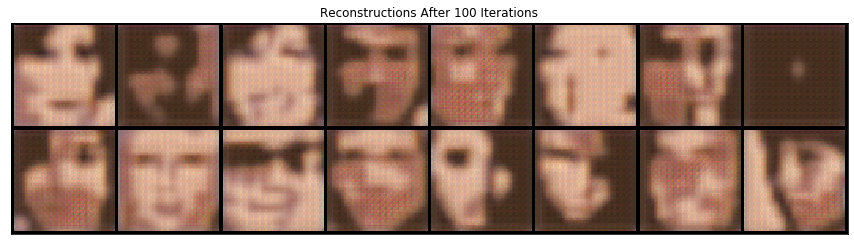

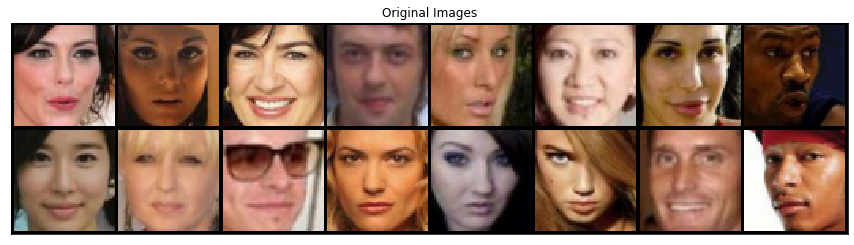

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


200 iterations
recon_error: 0.011
perplexity: 7.490



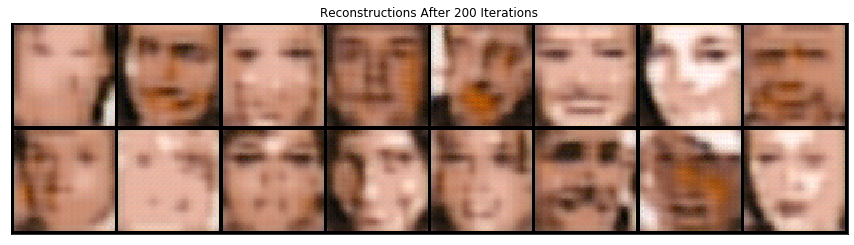

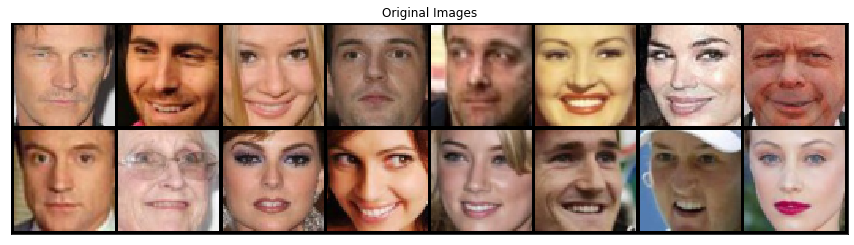

KeyboardInterrupt: 

In [27]:
model.train()

train_res_recon_error = []
train_res_perplexity = []

for i in range(num_training_updates):
    data = next(iter(train_dl))
    data = data.to(device)
    
    # zero gradients
    optimizer.zero_grad()
    
    # forward pass to calculate vector quantizer loss, reconstructions and perplexity
    vq_loss, data_recon, perplexity = model(data)
    
    # calculate reconstruction erros for given batch (divided by calculated data variance)
    recon_error = F.mse_loss(data_recon, data) / DATASET_VARIANCE
    
    # calculate full loss (reconstruction loss + vector quantizer loss)
    loss = recon_error + vq_loss
    
    # backward pass to update weights
    loss.backward()
    optimizer.step()
    
    # save reconstruction error and perplexity values
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())
    
    # show original reconstructions and images for every n-th iteration on batches 
    if (i+1) % SHOW_EVERY_N_ITERATION == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-SHOW_EVERY_N_ITERATION:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-SHOW_EVERY_N_ITERATION:]))
        print()
        
        show_batch(data_recon.cpu().detach(), samples=16, title=f'Reconstructions After {i+1} Iterations')
        show_batch(data.cpu().detach(), samples=16, title=f'Original Images')

### add quantized vectors in projector after training

In [28]:
add_quantized_vectors_to_projector(model, tag=f'model_{num_training_updates}_iter_{batch_size}_bs')

## Plot Loss

Apply [savgol_filter](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.savgol_filter.html) to have smooth curves

In [29]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, window_length=201, polyorder=7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, window_length=201, polyorder=7)

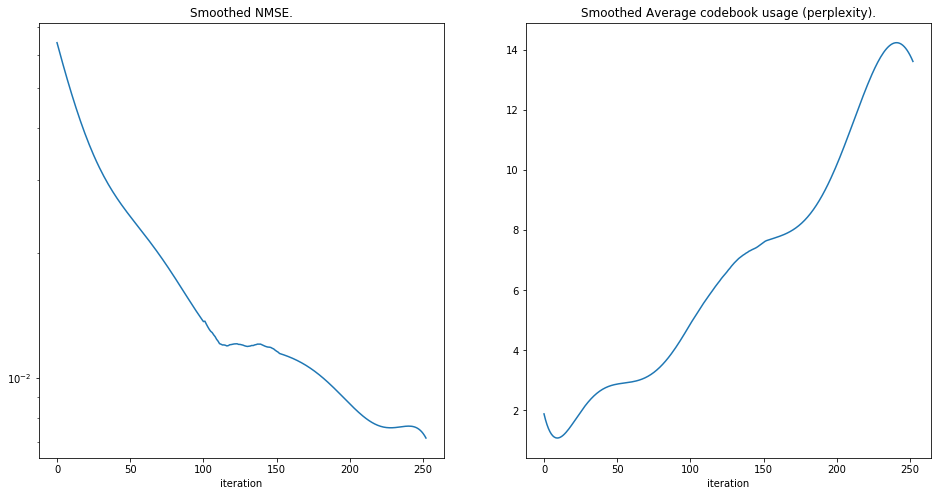

In [30]:
f = plt.figure(figsize=(16,8))

ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration');

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration');

Here is the same plot for fully trained model (`batch_size = 256` `num_training_updates = 500`)

![title](https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/vq_vae_training_stats.png)

## Retrieve Fully Trained Model

In [24]:
if not os.path.exists('vq_vae.model'):
    !wget https://maxinai-public-datasets.s3.eu-central-1.amazonaws.com/workshop-amld2020/vq_vae.model

In [25]:
full_model = Model(num_hiddens, num_residual_layers, num_residual_hiddens, 
              num_embeddings, embedding_dim, 
              commitment_cost).to(device)
full_model.load_state_dict(torch.load('vq_vae.model'))

<All keys matched successfully>

### add quantized vectors in projector for fully trained model

In [33]:
add_quantized_vectors_to_projector(full_model, tag=f'model_15000_iter_256_bs')

## View Reconstructions

In [26]:
valid_originals = next(iter(valid_dl)).to(device)

In [27]:
model.eval();
full_model.eval();

In [28]:
# partially trained model reconstructions
vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)


# fully trained model reconstructions
full_vq_output_eval = full_model._pre_vq_conv(full_model._encoder(valid_originals))
_, full_valid_quantize, _, _ = full_model._vq_vae(full_vq_output_eval)
full_valid_reconstructions = full_model._decoder(full_valid_quantize)

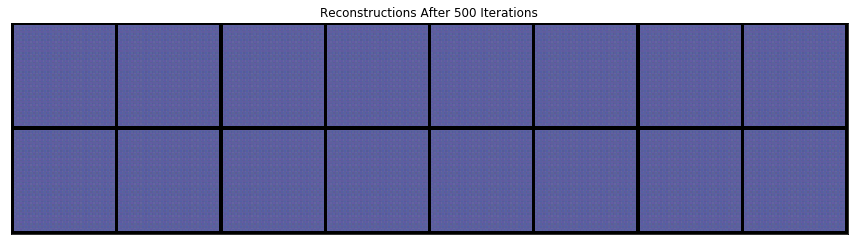

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


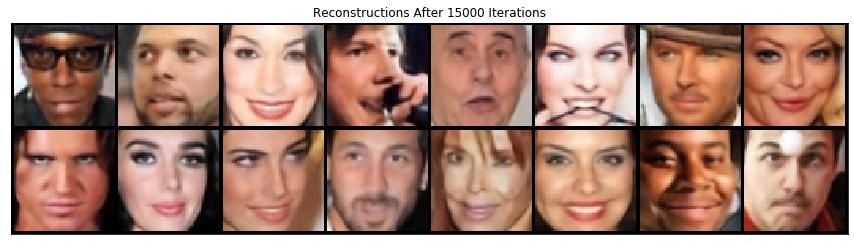

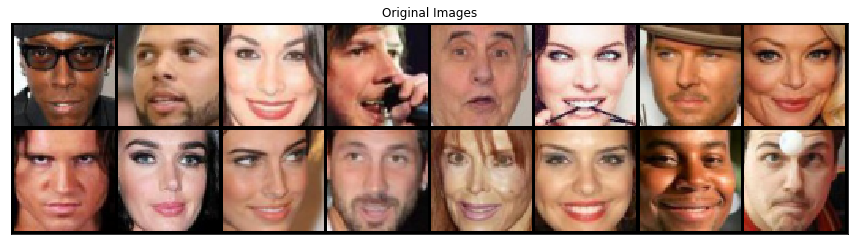

In [29]:
show_batch(valid_reconstructions.cpu().detach(), samples=16, 
           title=f'Reconstructions After {num_training_updates} Iterations')
show_batch(full_valid_reconstructions.cpu().detach(), samples=16, 
           title=f'Reconstructions After 15000 Iterations')
show_batch(valid_originals.cpu().detach(), samples=16, 
           title=f'Original Images')

## View Projected codebook vectors

Here you can check how codebook vectors of quantization part was look like at the beginning, after some training and long training. You will see that vectors are shaping sphere to the end. Intuitively it can be explained with increasing perplexity values which makes encoder to generate such features of which quantization is equally using all codebook vectors instead of just some of them. As all vectors should be used equally they are representing different features that can be matched to some human concept or group of concepts since they aren't proven to give disentangled feature representations.

The intuitive explanation isn't 100% correct, since we don't have proofs. It's our thought here which can be wrong!

### Run Tensorboard

Use ```%tensorboard --host=<your_host> --port <your_port> --logdir=runs``` for Custom Host and Port 

In [42]:
%tensorboard --host=0.0.0.0 --port 8988 --logdir=runs

Reusing TensorBoard on port 8988 (pid 16294), started 5 days, 2:14:58 ago. (Use '!kill 16294' to kill it.)

In [40]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 30539), started 0:00:10 ago. (Use '!kill 30539' to kill it.)

## Experiments with Visual Arithmetic in Latent Space

Similar to word2vec, we can do try some pretty interesting visual experiments by performing arithmetics in latent space of quantized vectors which isn't smooth compared to VAE. 

For example, we can manipulate certain facial attributes (e.g. wearing sunglasses, having a smile, long hair, etc...) on a picture by simply adding/subtracting the some vectors.

Below we will show how to paint sunglasses and smile on an arbitrary image.

Let's compare that to Variational Autoencoder results.

In [53]:
# This function selects some images having a certain characteristic (e.g Glasses, Long Hair, etc...) and averages their
# latent vectors in order to get a vector encoding this characteristic.

def get_mean_vec(model: nn.Module, df: pd.DataFrame, condition, samples=250):

    model.cpu()
    
    images = []
    for i, im_id in enumerate(df[condition].image_id.values):
        images.append(valid_dl.dataset.get_by_id(im_id))
        if i >= samples-1:
            break
        
    images = torch.stack(images)
    
    encoded_images = model.quantize(images)
        
    return torch.mean(encoded_images, dim=0, keepdim=True)

In [54]:
def show_decoded(encoded:torch.Tensor, model:nn.Module):
    dec_img = model.cpu().decode(encoded)
    denorm_dec_img = denorm(dec_img).detach()[0].numpy()
    plt.imshow(denorm_dec_img.transpose(1,2,0))

In [55]:
# now we are going to use above computed vectors to generate images with glasses.

def add_features_to_images(model: nn.Module, mean_vector:torch.Tensor, df: pd.DataFrame, condition, samples=16):
    model.cpu()
    
    images = []
    for i, im_id in enumerate(df[condition].image_id.values):
        images.append(valid_dl.dataset.get_by_id(im_id))
        if i >= samples - 1:
            break
        
    images = torch.stack(images)
    
    encoded_images = model.quantize(images)
    decoded_images = model.decode(encoded_images)
    
    shifted_images = encoded_images + mean_vector
    
    decoded_shifted_images = model.decode(shifted_images)
    
    all_images = torch.cat([decoded_images, decoded_shifted_images])
        
    return all_images

### Eyeglasses

In [33]:
# computing mean vectors of "wearing glasses" and "not wearing glasses"
glasses1 = get_mean_vec(full_model, attr_df, (attr_df.Eyeglasses == 1), samples=500)
glasses0 = get_mean_vec(full_model, attr_df, (attr_df.Eyeglasses == -1), samples=500)

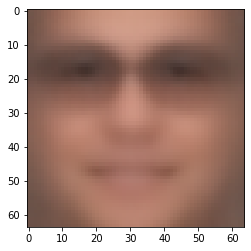

In [34]:
show_decoded(glasses1, full_model)

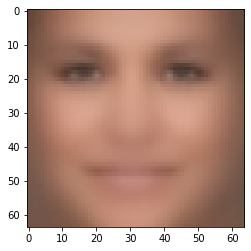

In [35]:
show_decoded(glasses0, full_model)

Here we see that Eyeglasses vector contains some noise around eyeglasses but it still showes something close to real

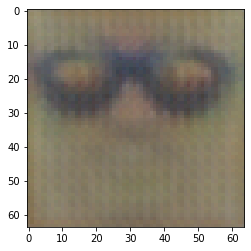

In [36]:
show_decoded(glasses1-glasses0, full_model)

In [37]:
featured_images_batch = add_features_to_images(full_model, glasses1, attr_df, attr_df.Eyeglasses == -1, samples=8)

Adding sunglasses to face didn't work well

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


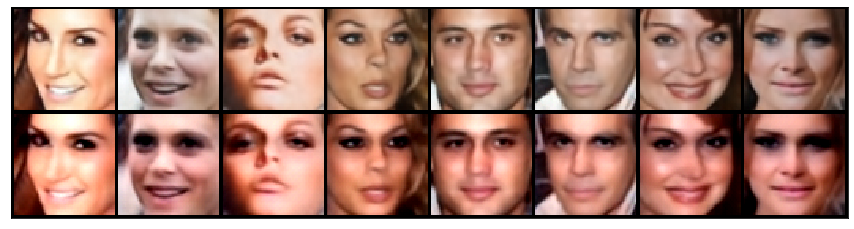

In [38]:
show_batch(featured_images_batch.cpu().detach())

### Smile

In [39]:
# computing mean vectors of "Smiling" and "not Smiling"
smile1 = get_mean_vec(full_model, attr_df, (attr_df.Smiling == 1), samples=500)
smile0 = get_mean_vec(full_model, attr_df, (attr_df.Smiling == -1), samples=500)

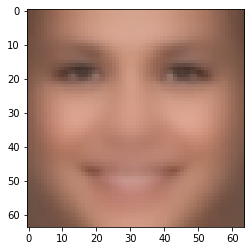

In [40]:
show_decoded(smile1, full_model)

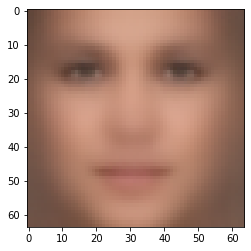

In [41]:
show_decoded(smile0, full_model)

We have noise around smile again

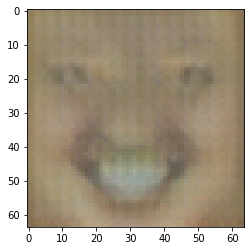

In [42]:
show_decoded(smile1-smile0, full_model)

In [43]:
featured_images_batch = add_features_to_images(full_model, smile1, attr_df, attr_df.Smiling == -1, samples=8)

Smiles is working slightly but doing changes to face color which means that smiling vector also contains other features

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


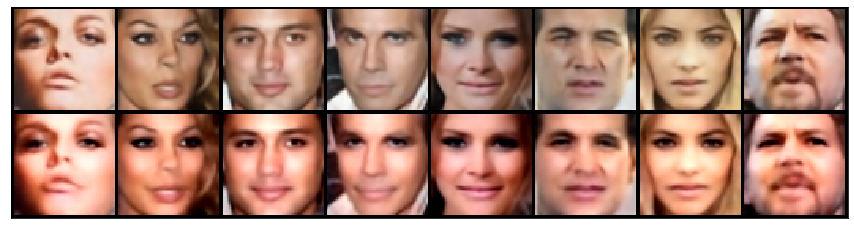

In [44]:
show_batch(featured_images_batch.cpu().detach())

Now we will visualize the 2D manifold where axes encode "Smile" and "Wearing Sunglasses"

In [46]:
# mean Z vector of no smile and with eyeglasses
z_no_glass_smile = get_mean_vec(full_model, attr_df, (attr_df.Eyeglasses == -1) & (attr_df.Smiling == 1), samples=500)

# mean Z vector of smile and with no eyeglasses
z_glass_no_smile = get_mean_vec(full_model, attr_df, (attr_df.Eyeglasses == 1) & (attr_df.Smiling == -1), samples=500)

# mean Z vector of no smile and with no eyeglasses
z_no_glass_no_smile = get_mean_vec(full_model, attr_df, (attr_df.Eyeglasses == -1) & (attr_df.Smiling == -1), samples=500)

### Show 2D space of Smile and Sunglasses basis

Trying to get average smile and sunglesses basis vectors and check how smoothly it will go from smile to non-smile and sunglasses to non-sunglasses.
Let's check what it does.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


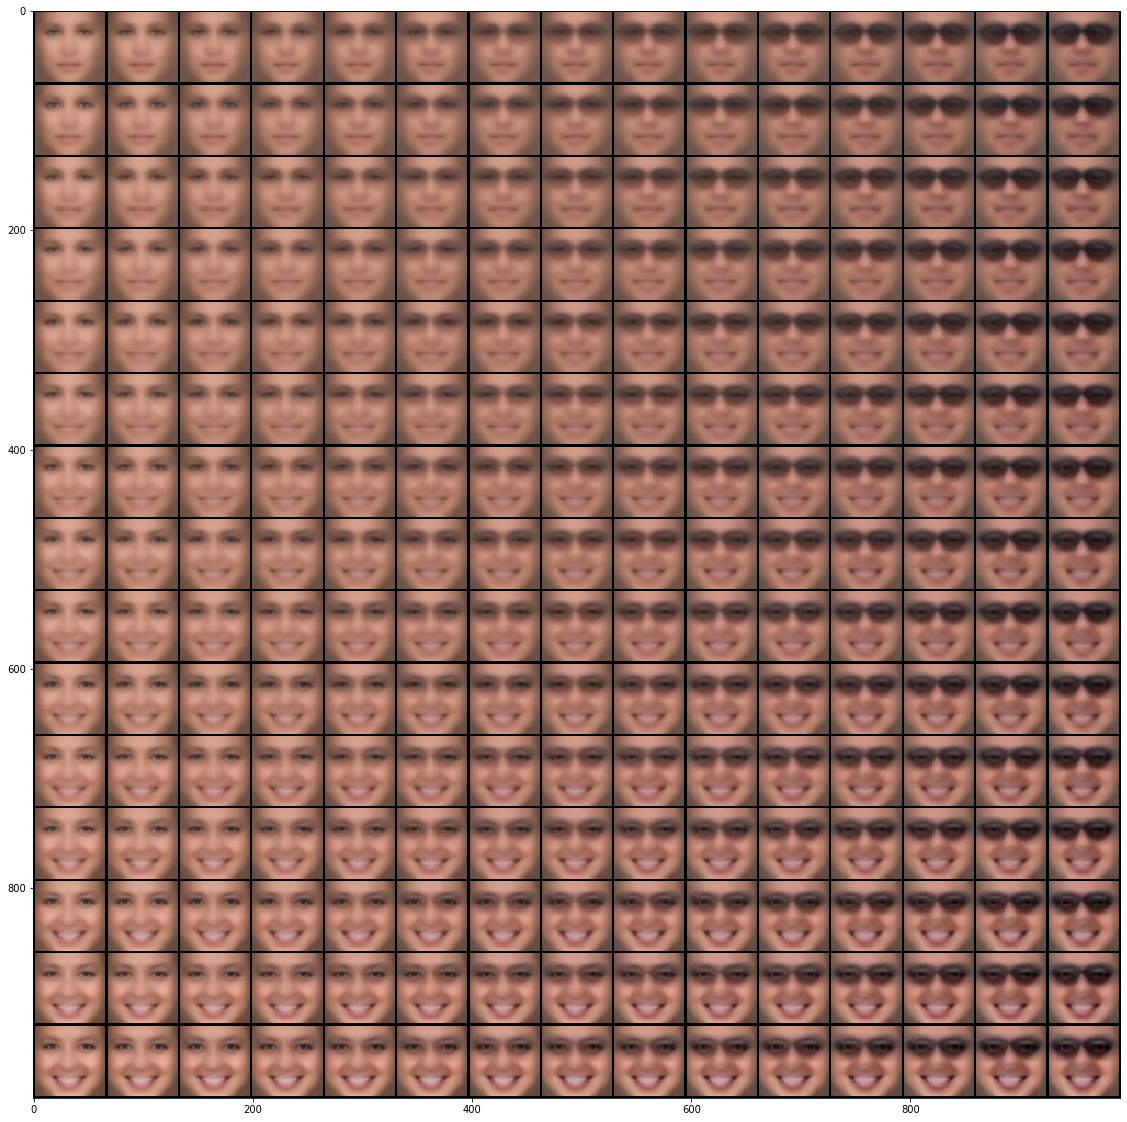

In [47]:
line = np.linspace(0, 2, 15)

# definining 2D basis vectors
I, J = z_no_glass_smile- z_no_glass_no_smile, z_glass_no_smile - z_no_glass_no_smile

res = []
for a in line:
    for b in line:
        z = z_no_glass_no_smile + a * I + b * J
        x_recon = denorm(full_model.decode(z))
        res.append(x_recon)
        
# displaying space

grd = make_grid(torch.cat(res, dim=0), 15).detach().numpy()
plt.figure(figsize=(20, 20))
plt.imshow(grd.transpose(1, 2, 0))

It seemed to work for that case. Maybe because averaging does some `smoothing` in discrete latent space.